In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

2024-08-13 17:04:16.031631: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 17:04:16.053329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 17:04:16.053355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 17:04:16.054130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 17:04:16.058196: I tensorflow/core/platform/cpu_feature_guar

当特征值的取值范围不同的时候，需要进行标准化，减去平均值，除以标准差

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [3]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()                                  #1
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#1 - Because you’ll need to instantiate the same model multiple times, you use a function to construct it.	

- 当数据量小的时候，为了留出验证集，使用Ｋ折交叉验证，用循环来实现，对每一次的验证分取平均
- 验证集用于可视化模型的训练效果，来指导调参，调好的参数可以在所有的训练数据上进行训练，生成最后的模型

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    #1
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                     #2
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    #3
    history = model.fit(partial_train_data, partial_train_targets,           #4
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
#1 - Prepares the validation data: data from partition #k
#2 - Prepares the training data: data from all other partitions
#3 - Builds the Keras model (already compiled)
#4 - Trains the model (in silent mode, verbose=0)

processing fold # 0
Epoch 1/100


2024-08-13 17:04:17.057573: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 17:04:17.076310: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 17:04:17.078529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 50/303 [===>..........................] - ETA: 0s - loss: 591.0598 - mae: 22.4379  

2024-08-13 17:04:17.716918: I external/local_xla/xla/service/service.cc:168] XLA service 0x70ca5ac30060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-13 17:04:17.716935: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-13 17:04:17.719468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 17:04:17.732159: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1723539857.753743   51633 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


303/303 [==============================] - 1s 1ms/step - loss: 226.5472 - mae: 11.4515 - val_loss: 36.9501 - val_mae: 4.0706
Epoch 2/100
303/303 [==============================] - 0s 1ms/step - loss: 33.6925 - mae: 4.0631 - val_loss: 25.8838 - val_mae: 3.1266
Epoch 3/100
303/303 [==============================] - 0s 1ms/step - loss: 23.8688 - mae: 3.2634 - val_loss: 19.6546 - val_mae: 3.0471
Epoch 4/100
303/303 [==============================] - 0s 1ms/step - loss: 19.6231 - mae: 2.9849 - val_loss: 17.5988 - val_mae: 2.7657
Epoch 5/100
303/303 [==============================] - 0s 1ms/step - loss: 17.1895 - mae: 2.7463 - val_loss: 13.7280 - val_mae: 2.3992
Epoch 6/100
303/303 [==============================] - 0s 1ms/step - loss: 15.0265 - mae: 2.6508 - val_loss: 12.4648 - val_mae: 2.2159
Epoch 7/100
303/303 [==============================] - 0s 1ms/step - loss: 13.7010 - mae: 2.4985 - val_loss: 14.9101 - val_mae: 2.6240
Epoch 8/100
303/303 [==============================] - 0s 1ms/ste

In [5]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

绘图要去掉特殊的数据点，并且让图像变平滑

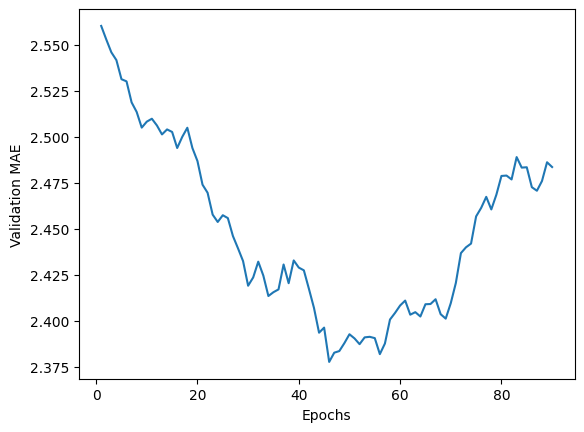

In [6]:
import matplotlib.pyplot as plt
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

找到正确的epoch后，在最后的模型上训练

In [7]:
# model = build_model()                                                     #1
# model.fit(train_data, train_targets,                                      #2
#           epochs=60, batch_size=16, verbose=0)
# test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

# #1 - Gets a fresh, compiled model
# #2 - Trains it on the entirety of the data